In [1]:
import os
import tensorflow as tf
import keras
from keras import Sequential
from keras.models import Model
from keras.layers import *

import matplotlib.pyplot as plt
import cv2
import numpy as np

# DATA

Unprocessed Original Dataset = https://www.kaggle.com/datasets/bijoyroy/human-segmentation-dataset

I get the masks from coordinates of polygon and applied data augmentation. Both images and masks are resized to (256,256). Image shape is (256,256,3), mask shape is (256,256,1). Later images are normalized. TFRecord datasets are shuffled and batched with 32. Datasets are ready to use in training.

### Load the dataset

Loading datasets I processed and compressed.

In [2]:
!tar -zxvf {'archive.tar.gz'}

In [3]:
train = tf.data.Dataset.load('Data/train.tfrecord')
test = tf.data.Dataset.load('Data/test.tfrecord')

In [4]:
train, test

(<_LoadDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float16, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.uint8, name=None))>,
 <_LoadDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float16, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.uint8, name=None))>)

# MODEL

### Loss Function

In [5]:
def dice_loss_func(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return 1 -(2.0 * intersection + 1) / (union + 1)

def loss_func(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    binary_cross_entropy_loss = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dice_loss = dice_loss_func(y_true, y_pred)
    return binary_cross_entropy_loss + 3*dice_loss

### U-Net

In [6]:
class UNet(Model):
  def __init__(self):
    super(UNet, self).__init__()
    # Encoder part
    self.conv_block1 = self.double_conv(64)
    self.max_pool1 = MaxPooling2D(2)

    self.conv_block2 = self.double_conv(128)
    self.max_pool2 = MaxPooling2D(2)

    self.conv_block3 = self.double_conv(256)
    self.max_pool3 = MaxPooling2D(2)

    self.conv_block4 = self.double_conv(512)
    self.max_pool4 = MaxPooling2D(2)

    self.conv_block5 = self.double_conv(1024)

    # Decoder part
    self.up_conv1 = Conv2DTranspose(512, 3, 2, padding='same')
    self.concat1 = Concatenate()
    self.conv_block6 = self.double_conv(512)

    self.up_conv2 = Conv2DTranspose(256, 3, 2, padding='same')
    self.concat2 = Concatenate()
    self.conv_block7 = self.double_conv(256)

    self.up_conv3 = Conv2DTranspose(128, 3, 2, padding='same')
    self.concat3 = Concatenate()
    self.conv_block8 = self.double_conv(128)

    self.up_conv4 = Conv2DTranspose(64, 3, 2, padding='same')
    self.concat4 = Concatenate()
    self.conv_block9 = self.double_conv(64)

    self.out = Conv2D(1, 1, padding="same", activation='sigmoid')


  def double_conv(self, kernel):
    block = Sequential([Conv2D(kernel, 3, activation='relu', padding='same', kernel_initializer = "he_normal"),
                        Conv2D(kernel, 3, activation='relu', padding='same', kernel_initializer = "he_normal")])
    return block


  def build(self, input_shape):
    self.input_spec = InputSpec(shape=input_shape)
    super(UNet, self).build(input_shape)


  def call(self, inputs):

    # Encoder
    x = self.conv_block1(inputs)

    y = self.max_pool1(x)
    y = self.conv_block2(y)

    z = self.max_pool2(y)
    z = self.conv_block3(z)

    v = self.max_pool3(z)
    v = self.conv_block4(v)

    f = self.max_pool4(v)
    f = self.conv_block5(f)

    # Decoder
    f = self.up_conv1(f)
    f = self.concat1([v,f])
    f = self.conv_block6(f)

    f = self.up_conv2(f)
    f = self.concat2([z,f])
    f = self.conv_block7(f)

    f = self.up_conv3(f)
    f = self.concat3([y,f])
    f = self.conv_block8(f)

    f = self.up_conv4(f)
    f = self.concat4([x,f])
    f = self.conv_block9(f)

    return self.out(f)

### Building the model

In [7]:
input_shape=(None,256,256,3)
model = UNet()
model.build(input_shape)
model.compile(optimizer='adam', loss=loss_func, metrics=['accuracy'])

### Training the model

In [8]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(train, epochs=40, validation_data=test, callbacks=[earlystopping])

Epoch 1/40
65/65 [==============================] - 42s 260ms/step - loss: 2.6901 - accuracy: 0.8122 - val_loss: 2.2145 - val_accuracy: 0.8368
Epoch 2/40
65/65 [==============================] - 13s 199ms/step - loss: 2.0676 - accuracy: 0.8602 - val_loss: 1.7713 - val_accuracy: 0.8743
Epoch 3/40
65/65 [==============================] - 13s 199ms/step - loss: 1.6932 - accuracy: 0.8899 - val_loss: 1.6082 - val_accuracy: 0.8853
Epoch 4/40
65/65 [==============================] - 13s 198ms/step - loss: 1.5672 - accuracy: 0.8968 - val_loss: 1.4229 - val_accuracy: 0.9074
Epoch 5/40
65/65 [==============================] - 13s 198ms/step - loss: 1.4032 - accuracy: 0.9087 - val_loss: 1.3345 - val_accuracy: 0.9057
Epoch 6/40
65/65 [==============================] - 13s 199ms/step - loss: 1.2826 - accuracy: 0.9160 - val_loss: 1.3084 - val_accuracy: 0.9188
Epoch 7/40
65/65 [==============================] - 13s 199ms/step - loss: 1.1491 - accuracy: 0.9253 - val_loss: 1.0158 - val_accuracy: 0.9292

### Testing the model

In [9]:
sample = test.as_numpy_iterator().next()

##### Original image and original mask

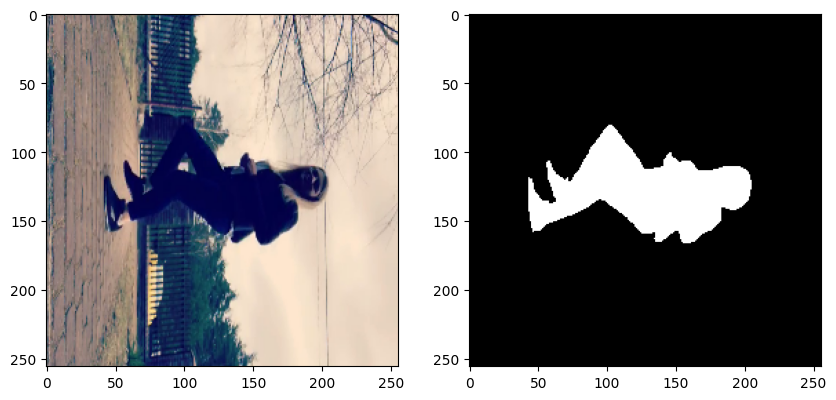

In [10]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
ax[0].imshow(tf.cast(sample[0][-1]*255, dtype=tf.uint8))
ax[1].imshow(tf.cast(sample[1][-1], dtype=tf.uint8), cmap='gray')

##### Model's output mask

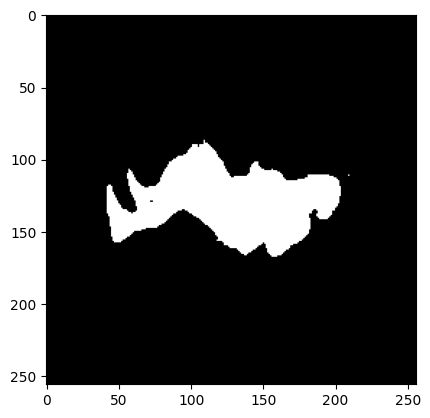

In [15]:
mask = model(sample[0])

mask = np.where(mask > 0.2, 1, mask)
mask = np.where(mask < 0.2, 0, mask)

plt.imshow(mask[-1], cmap='gray')

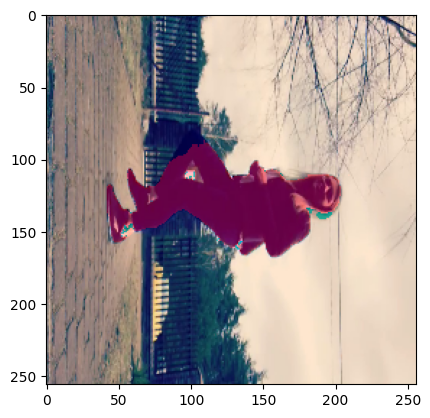

In [12]:
new = sample[0][-1].copy()*255
density = 100
for row in range(new.shape[0]):
    for col in range(new.shape[1]):
        if mask[-1][row][col] == 1 :
            if new[row][col][0] < 205:
                new[row][col][0] += density
            else:
                new[row][col][0] = 255

plt.imshow(tf.cast(new, dtype=tf.uint8))

### Saving the model

In [13]:
tf.saved_model.save(model, 'UNet')